In [1]:


%load_ext autoreload
%autoreload 2
%matplotlib inline



In [13]:
# pytorch imports
import wget
import torch
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.autograd import Variable

import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import random
from tqdm import tqdm_notebook as tqdm
import math
import time
from IPython.core.debugger import set_trace

In [4]:
print("cuda" if torch.cuda.is_available() else "cpu")

bs = 64
epochs = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imagenet_stats = [(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)]



cuda


In [ ]:
FOOD_PATH = "./food-101"
IMG_PATH = FOOD_PATH+"/images"
META_PATH = FOOD_PATH+"/meta"
TRAIN_PATH = FOOD_PATH+"/train"
VALID_PATH = FOOD_PATH+"/valid"
MODEL_PATH = 'model_data/'



In [ ]:


gpu = True if torch.cuda.is_available() else False
gpu



In [5]:
filename = MODEL_PATH+'clr.pth'

In [6]:
def pp_(*args, n_dash=120):
    for arg in args:
        print(arg)
        print("-"*n_dash)

def list_dir(path="./"): return os.listdir(path)

def cal_mean_std(train_data):
    return np.mean(train_data, axis=(0,1,2))/255, np.std(train_data, axis=(0,1,2))/255

def save_checkpoint(model, is_best, filename='model_data/checkpoint.pth'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")
        
# from fastai library
def load_checkpoint(model, filename = 'model_data/checkpoint.pth'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)        

def save_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_model(model, path):
    model.load_state_dict(torch.load(path))    

def calc_iters(dataset, num_epochs, bs):
    return int(len(dataset) * num_epochs /bs)

def accuracy(output, target, is_test=False):
    global total
    global correct
    batch_size = output.shape[0]
    total += batch_size
    
    _, pred = torch.max(output, 1)
    if is_test:
        preds.extend(pred)
    correct += (pred == target).sum()
    return 100 * correct / total

class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)

def freeze(model):
    child_counter = 0
    for name, child in model.named_children():
        if child_counter < 7:
            print("name ",name, "child ",child_counter," was frozen")
            for param in child.parameters():
                param.requires_grad = False
        elif child_counter == 7:
            children_of_child_counter = 0
            for children_of_child in child.children():
                if children_of_child_counter < 2:
                    for param in children_of_child.parameters():
                        param.requires_grad = False
                    print("name ",name, 'child ', children_of_child_counter, 'of child',child_counter,' was frozen')
                else:
                    print("name ",name, 'child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
                children_of_child_counter += 1

        else:
            print("name ",name, "child ",child_counter," was not frozen")
        child_counter += 1

def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True

def print_frozen_state(model):
    child_counter = 0
    for name, child in model.named_children():
        for param in child.parameters():
            if param.requires_grad == True:
                print("child ",child_counter,"named:",name," is unfrezed")
            elif param.requires_grad == False:
                print("child ",child_counter,"named:",name," is frezed")
        child_counter += 1

def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom



In [14]:
class FOOD101():
    def __init__(self):
        self.train_ds, self.valid_ds, self.train_cls, self.valid_cls = [None]*4
        self.imgenet_mean = imagenet_stats[0]
        self.imgenet_std = imagenet_stats[1]
   
    def get_data_extract(self):
        if "food-101" in os.listdir():
            print("Dataset already exists")
        else:
            print("Downloading the data...")
            wget.download("http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz")
            print("Dataset downloaded!")
            print("Extracting data..")
            !tar xzvf food-101.tar.gz
            print("Extraction done!")
        
    def _get_tfms(self):
        train_tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])
        
        valid_tfms = transforms.Compose([
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(self.imgenet_mean, self.imgenet_std)])        
        return train_tfms, valid_tfms            
            
    def get_dataset(self,root_dir='./food-101/'):
        train_tfms, valid_tfms = self._get_tfms() # transformations
        self.train_ds = datasets.ImageFolder(root=TRAIN_PATH, transform=train_tfms)
        self.valid_ds = datasets.ImageFolder(root=VALID_PATH, transform=valid_tfms)        
        self.train_classes = self.train_ds.classes
        self.valid_classes = self.valid_ds.classes

        assert self.train_classes==self.valid_classes
        return self.train_ds, self.valid_ds, self.train_classes

    
    def get_dls(self, train_ds, valid_ds, bs, **kwargs):
        return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
               DataLoader(valid_ds, batch_size=bs//2, shuffle=False, **kwargs))
    
food = FOOD101()    

In [15]:
food.get_data_extract()

Dataset downloaded!
Extracting data..
Extraction done!


x food-101/
x food-101/images/
x food-101/images/beignets/
x food-101/images/beignets/2885220.jpg
x food-101/images/beignets/1814040.jpg
x food-101/images/beignets/81202.jpg
x food-101/images/beignets/1827892.jpg
x food-101/images/beignets/2802124.jpg
x food-101/images/beignets/2192983.jpg
x food-101/images/beignets/250043.jpg
x food-101/images/beignets/2786548.jpg
x food-101/images/beignets/445116.jpg
x food-101/images/beignets/3661460.jpg
x food-101/images/beignets/1064858.jpg
x food-101/images/beignets/2993714.jpg
x food-101/images/beignets/2936669.jpg
x food-101/images/beignets/1062952.jpg
x food-101/images/beignets/2869806.jpg
x food-101/images/beignets/178659.jpg
x food-101/images/beignets/1261083.jpg
x food-101/images/beignets/1296128.jpg
x food-101/images/beignets/3157161.jpg
x food-101/images/beignets/646871.jpg
x food-101/images/beignets/3438314.jpg
x food-101/images/beignets/3019700.jpg
x food-101/images/beignets/1133765.jpg
x food-101/images/beignets/1199143.jpg
x food-101/

x food-101/images/peking_duck/1689311.jpg
x food-101/images/peking_duck/63425.jpg
x food-101/images/peking_duck/540537.jpg
x food-101/images/peking_duck/669430.jpg
x food-101/images/peking_duck/2923727.jpg
x food-101/images/peking_duck/596294.jpg
x food-101/images/peking_duck/1122542.jpg
x food-101/images/peking_duck/2824039.jpg
x food-101/images/peking_duck/3270633.jpg
x food-101/images/peking_duck/1909414.jpg
x food-101/images/peking_duck/640286.jpg
x food-101/images/peking_duck/1836326.jpg
x food-101/images/peking_duck/535775.jpg
x food-101/images/peking_duck/844640.jpg
x food-101/images/peking_duck/633870.jpg
x food-101/images/peking_duck/3009471.jpg
x food-101/images/peking_duck/2725459.jpg
x food-101/images/peking_duck/3639145.jpg
x food-101/images/peking_duck/1698258.jpg
x food-101/images/peking_duck/2383763.jpg
x food-101/images/peking_duck/1124164.jpg
x food-101/images/peking_duck/2167093.jpg
x food-101/images/peking_duck/2495195.jpg
x food-101/images/peking_duck/3659586.jpg
x

In [16]:
!ls food-101/

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [17]:
pp_(list_dir(FOOD_PATH), list_dir(IMG_PATH), list_dir(META_PATH))

['images', 'license_agreement.txt', 'meta', 'README.txt']
------------------------------------------------------------------------------------------------------------------------
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hambur

In [18]:


!head food-101/meta/train.txt

'head' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src, dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')

    for food in classes_images.keys():
        print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!")

In [24]:
prepare_data(META_PATH+'/train.txt', IMG_PATH, TRAIN_PATH)
prepare_data(META_PATH+'/test.txt', IMG_PATH, VALID_PATH)


Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying images into  croque_madam

In [25]:
train_ds, valid_ds, classes =  food.get_dataset()
num_classes = len(classes)
pp_(classes,num_classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [26]:
train_dl, valid_dl = food.get_dls(train_ds, valid_ds, bs=bs, num_workers=2)

In [27]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
    
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset
    
    def __repr__(self):
        return str(self.__class__.__name__)+" obj (train & valid DataLoaders)"

In [28]:
data = DataBunch(train_dl, valid_dl, c=num_classes)

In [29]:


pp_(data.valid_ds, data.c, data.train_ds)



Dataset ImageFolder
    Number of datapoints: 25250
    Root location: ./food-101/valid
    StandardTransform
Transform: Compose(
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
------------------------------------------------------------------------------------------------------------------------
101
------------------------------------------------------------------------------------------------------------------------
Dataset ImageFolder
    Number of datapoints: 75750
    Root location: ./food-101/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
--------------------------------------

In [30]:
def show_ds(trainset, classes, validset=None, cols=6, rows=17, preds=None, is_pred=False, is_valid=False):        
    fig = plt.figure(figsize=(25,25))
    fig.suptitle(f"Showing one random image from each {'Validation' if is_valid else 'Train'} classes", y=0.92, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
    columns = cols
    rows = rows
    imgenet_mean = imagenet_stats[0]
    imgenet_std = imagenet_stats[1]  

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred and testset:
            img_xy = np.random.randint(len(testset));
            np_img = testset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))            
            img = img * imgenet_std + imgenet_mean
        else:
            img_xy = np.random.randint(len(trainset));
            np_img = trainset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))
            img = img * imgenet_std + imgenet_mean
        
        if is_pred:
            plt.title(classes[int(preds[img_xy])] + "/" + classes[testset[img_xy][1]])
        else:
            plt.title(classes[trainset[img_xy][1]])
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(img, interpolation='nearest')
    plt.show()

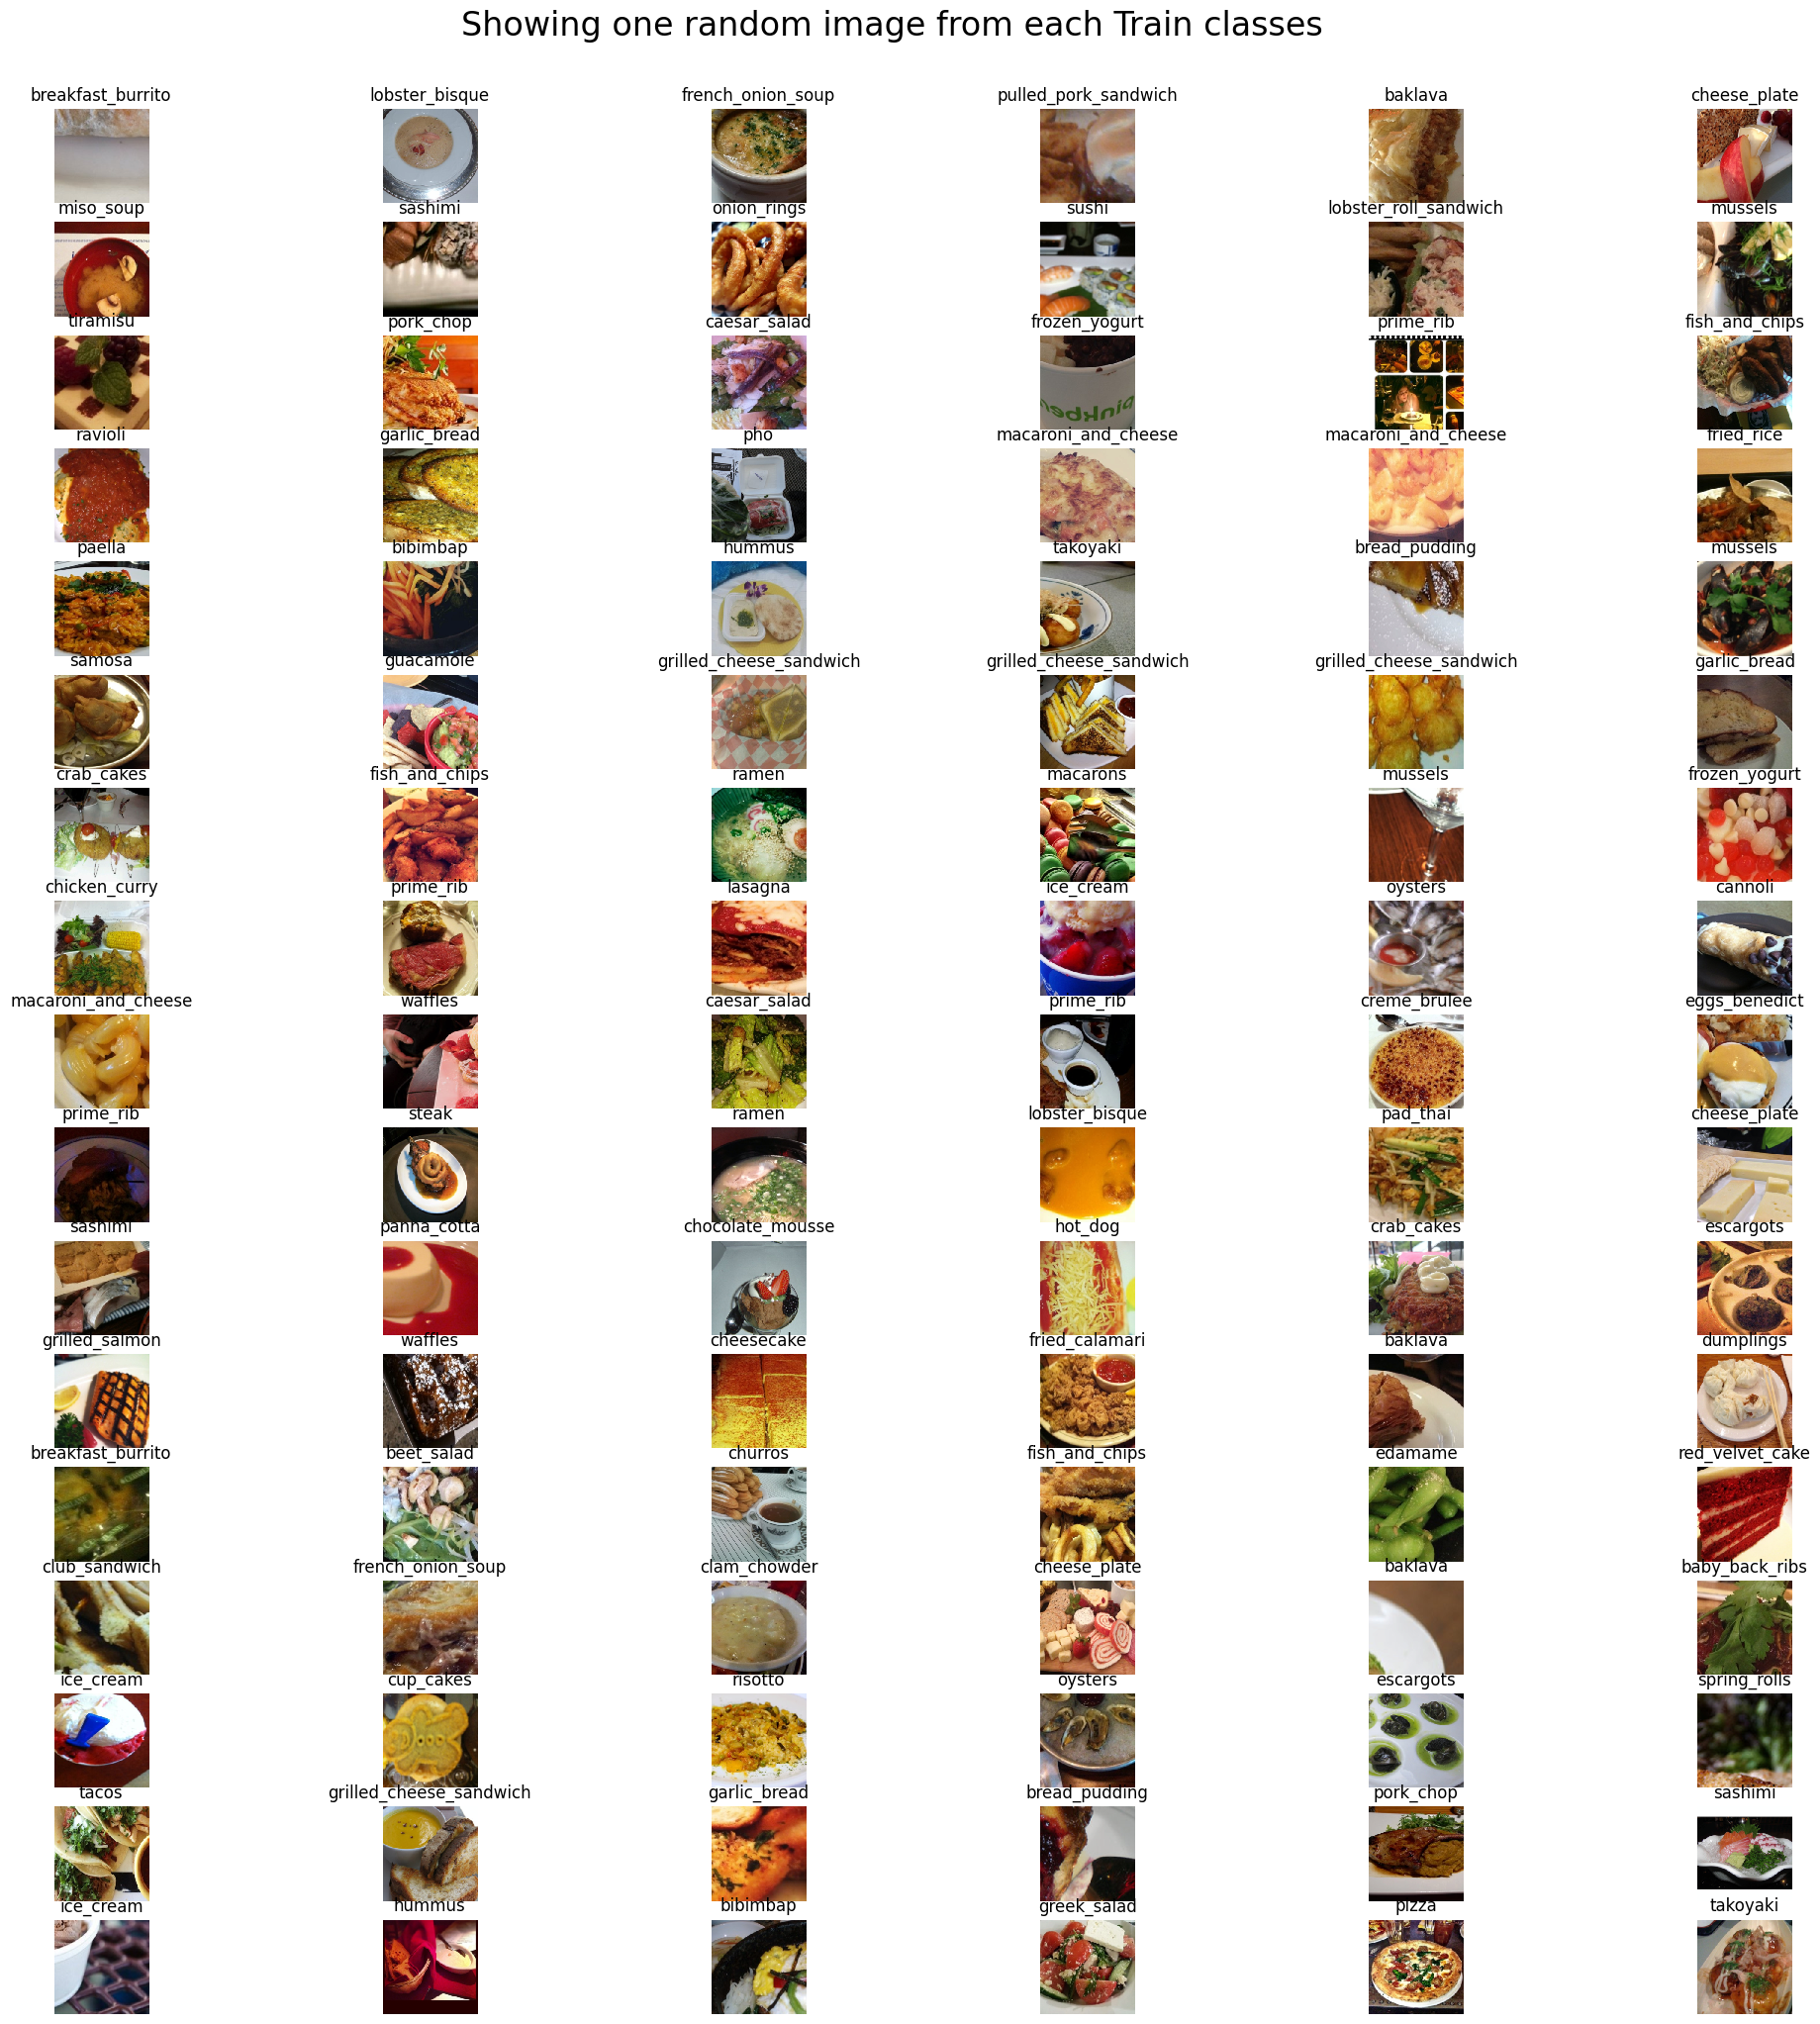

In [31]:
show_ds(data.train_ds, classes)